In [3]:
# !pip install geopandas folium matplotlib seaborn scipy
# !pip install esda
# !pip install splot
# # for google colab, had to reinstall some pacakges.

In [2]:
import pandas as pd
import numpy as np
from scipy import stats
import datetime as dt
import matplotlib
import matplotlib.pyplot as plt
import os
import io
import geopandas as gpd
import seaborn as sns

# suppress warning
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
file_path1 = '/content/drive/My Drive/X999/bbl_evictions_merged.csv'

In [7]:
file_path2 = '/content/drive/My Drive/X999/svi_cleaned.csv'

In [8]:
bbl_evictions_df = pd.read_csv(file_path1)

In [9]:
svi_df = pd.read_csv(file_path2)

In [11]:
columns_list = ['FIPS', 'E_TOTPOP', 'RPL_THEME1', 'RPL_THEME2', 'RPL_THEME3', 'RPL_THEME4', 'RPL_THEMES',
               'EP_POV150', 'EP_UNEMP', 'EP_NOHSDP', 'EP_UNINSUR','EP_AGE65', 'EP_AGE17', 'EP_DISABL', 'EP_LIMENG',
               'EP_NOVEH', 'EP_CROWD', 'EP_HBURD','EP_AFAM', 'EP_HISP', 'EP_ASIAN', 'EP_AIAN', 'EP_NHPI', 'EP_TWOMORE',
                'EP_OTHERRACE', 'EP_MINRTY']

In [12]:
# the cleaned svi df has changed all columns to lower case, so we will do it here too.
lowercase_columns = [col.lower() for col in columns_list]

In [14]:
svi_simplified = svi_df[lowercase_columns]
svi_simplified.head()

,fips,e_totpop,rpl_theme1,rpl_theme2,rpl_theme3,rpl_theme4,rpl_themes,ep_pov150,ep_unemp,ep_nohsdp,...,ep_crowd,ep_hburd,ep_afam,ep_hisp,ep_asian,ep_aian,ep_nhpi,ep_twomore,ep_otherrace,ep_minrty
0,10001,27004,0.5688,0.1692,0.8670,0.9806,0.7414,20.3,4.3,9.1,...,2.7,23.1,8.2,19.3,18.6,0.0,0.0,2.9,0.8,49.8
1,10002,76518,0.9639,0.8781,0.9369,0.9254,0.9656,36.8,7.6,30.0,...,6.8,40.8,8.0,26.0,37.2,0.1,0.0,2.4,0.8,74.4
2,10003,53877,0.3389,0.0969,0.7977,0.9368,0.5373,14.3,4.7,4.2,...,3.2,21.8,5.4,10.3,16.7,0.1,0.1,3.8,0.3,36.7
3,10004,4579,0.0252,0.0769,0.8439,0.8558,0.2299,3.7,0.4,0.9,...,7.6,6.1,5.5,5.0,29.9,0.0,0.0,3.5,0.0,43.9
4,10005,8801,0.0631,0.0427,0.7504,0.8496,0.2437,7.4,3.4,2.5,...,8.4,10.9,4.8,8.6,11.2,0.0,0.0,6.5,0.0,31.0


In [15]:
svi_df.shape, svi_simplified.shape

((204, 156), (204, 26))

In [17]:
svi_simplified['ep_white'] = 100 - svi_simplified['ep_minrty']

In [19]:
bbl_evictions_df.eviction_postcode.dtype, svi_simplified.fips.dtype

(dtype('int64'), dtype('int64'))

In [20]:
bbl_evictions_df['eviction_postcode'] = bbl_evictions_df['eviction_postcode'].astype(str)
svi_simplified['fips'] = svi_simplified['fips'].astype(str)

In [21]:
merged_df = pd.merge(bbl_evictions_df,
                    svi_simplified,
                    left_on='eviction_postcode',
                    right_on='fips',
                    how='left')

## After merging bbl_evictions_df and svi_simplified, we check nan, since rpl_themes is the most import column and any rows that have nan

In [31]:
merged_df.shape

(74082, 67)

In [32]:
nan_rows = merged_df[merged_df['rpl_themes'].isna()]
nan_rows # the zipcodes were not matches in this case and all the svi columns are nan

,court_index_number,docket_number,eviction_address,eviction_apartment_number,executed_date,borough,eviction_postcode,ejectment,eviction/legal_possession,latitude,...,ep_hburd,ep_afam,ep_hisp,ep_asian,ep_aian,ep_nhpi,ep_twomore,ep_otherrace,ep_minrty,ep_white
105,Q75285/16,74259,213 BEACH 99 STREET,2,2017-01-04,QUEENS,11694,Not an Ejectment,Possession,40.584419,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
132,Q72854/16,74382,711B SEAGIRT AVENUE,5M,2017-01-04,QUEENS,11691,Not an Ejectment,Possession,40.595996,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
200,Q65762/16,92015,180 BEACH 117TH STREET,2-E,2017-01-04,QUEENS,11694,Not an Ejectment,Possession,40.578958,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
205,Q59869/16,91103,171 BEACH 26TH ST,1,2017-01-04,QUEENS,11691,Not an Ejectment,Possession,40.594155,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
280,64250/16,7180,231 BEACH 100TH ST.,#1,2017-01-05,QUEENS,11694,Not an Ejectment,Possession,40.584585,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73941,0303331/23,22381,51-24 BEACH CHANNEL DRIVE,7B,2024-12-18,QUEENS,11691,Not an Ejectment,Possession,40.595255,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
73942,309866/22,17441,707 BEACH 9TH STREET,3P,2024-12-18,QUEENS,11691,Not an Ejectment,Possession,40.602163,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
73956,320832/23,140338,162 BEACH 116TH ST REET,3R,2024-12-18,QUEENS,11694,Not an Ejectment,Possession,40.578937,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
73960,301187/24,42289,180 BEACH 117TH STREET,#6K,2024-12-18,QUEENS,11694,Not an Ejectment,Possession,40.578958,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
missing_svi = merged_df['rpl_themes'].isna().sum()
print(missing_svi/len(merged_df)*100,"% missing rows")

2.22456197186901 % missing rows


In [34]:
missing_svi

np.int64(1648)

In [24]:
missing_postcodes = merged_df[merged_df['rpl_themes'].isna()]['eviction_postcode'].unique()
missing_postcodes

array(['11694', '11691', '11692', '11693', '11040', '10101', '11001',
       '11384', '11439', '11242', '10424', '11137', '11443', '11266',
       '11272', '11698', '10000', '11442', '10433', '11382', '10041',
       '11202', '11467', '10360', '10260'], dtype=object)

These zipcodes do not have matches. Roughly these neighborhoods: Neighborhoods were affected:
Rockaway Park, Belle Harbor, Neponsit, Roxbury, Far Rockaway, Bayswater, Arverne, Edgemere, Rockaway Beach, Hammels, New Hyde Park, Floral Park, Bellerose, Brooklyn Heights, Financial District.

In [35]:
missing_postcodes = merged_df[merged_df['rpl_themes'].isna()]['eviction_postcode'].unique()

In [36]:
merged_df_clean = merged_df[~merged_df['eviction_postcode'].isin(missing_postcodes)]
merged_df.shape, merged_df_clean.shape, len(merged_df) - len(merged_df_clean)

((74082, 67), (72434, 67), 1648)

In [ ]:
# merged_df_clean.columns

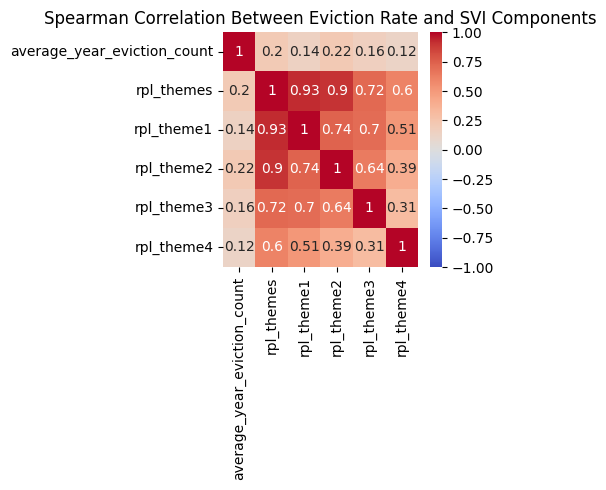

In [27]:
key_vars = ['average_year_eviction_count', 'rpl_themes', 'rpl_theme1', 'rpl_theme2', 'rpl_theme3', 'rpl_theme4']
correlation_heatmap = merged_df_clean[key_vars].corr(method='spearman')

plt.figure(figsize=(5, 5))
sns.heatmap(correlation_heatmap, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Spearman Correlation Between Eviction Rate and SVI Components')
plt.tight_layout()
plt.savefig('eviction_svi_correlation.png')

In [28]:
key_vars = ['average_year_eviction_count', 'rpl_themes', 'rpl_theme1', 'rpl_theme2', 'rpl_theme3', 'rpl_theme4']
correlation_results = {}

for var in key_vars[1:]:
    correlation, p_value = stats.spearmanr(merged_df_clean['average_year_eviction_count'], merged_df_clean[var])
    correlation_results[var] = {'correlation': correlation, 'p_value': p_value}

for var, results in correlation_results.items():
    significance = "significant" if results['p_value'] < 0.05 else "not significant"
    print(f"correlation between eviction rate and {var}: r = {results['correlation']:.3f}, p = {results['p_value']:.4f} ({significance})")

correlation between eviction rate and rpl_themes: r = 0.203, p = 0.0000 (significant)
correlation between eviction rate and rpl_theme1: r = 0.145, p = 0.0000 (significant)
correlation between eviction rate and rpl_theme2: r = 0.218, p = 0.0000 (significant)
correlation between eviction rate and rpl_theme3: r = 0.158, p = 0.0000 (significant)
correlation between eviction rate and rpl_theme4: r = 0.121, p = 0.0000 (significant)


The relatively weak correlations between eviction rates and SVI components suggest that evictions in NYC are not simply driven by social vulnerability as measured by the SVI. Other factors not captured in the SVI (such as local housing policies, landlord practices, or rental market conditions) likely play important roles.

The household composition/disability theme having the strongest correlation (but still weak) might indicate that household structure and disability status may be slightly more relevant to eviction risk than other vulnerability factors.

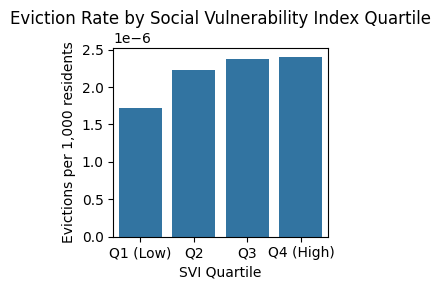

In [29]:
merged_df_clean['svi_quartile'] = pd.qcut(merged_df_clean['rpl_themes'], 4, labels=['Q1 (Low)', 'Q2', 'Q3', 'Q4 (High)'])
quartile_analysis = merged_df_clean.groupby('svi_quartile').agg({
    'average_year_eviction_count': 'mean',
    'eviction_count': 'sum',
    'e_totpop': 'sum'
}).reset_index()
quartile_analysis['total_eviction_rate'] = quartile_analysis['average_year_eviction_count'] / quartile_analysis['e_totpop'] * 1000
plt.figure(figsize=(3, 3))
sns.barplot(x='svi_quartile', y='total_eviction_rate', data=quartile_analysis)
plt.title('Eviction Rate by Social Vulnerability Index Quartile')
plt.ylabel('Evictions per 1,000 residents')
plt.xlabel('SVI Quartile')
plt.tight_layout()
plt.savefig('eviction_by_svi_quartile.png')

Though with fairly weak correlation, we do see more people with higher svi score experienced more evictions than others.

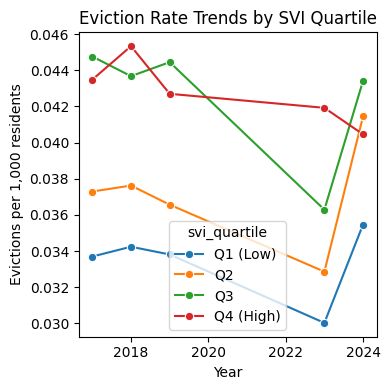

In [30]:
time_analysis = merged_df_clean.groupby(['year', 'svi_quartile']).agg({
    'average_year_eviction_count': 'sum',
    'e_totpop': 'sum'
}).reset_index()
time_analysis['yearly_eviction_rate'] = time_analysis['average_year_eviction_count'] / time_analysis['e_totpop'] * 1000

plt.figure(figsize=(4, 4))
sns.lineplot(x='year', y='yearly_eviction_rate', hue='svi_quartile', data=time_analysis, marker='o')
plt.title('Eviction Rate Trends by SVI Quartile')
plt.ylabel('Evictions per 1,000 residents')
plt.xlabel('Year')
plt.tight_layout()
plt.savefig('eviction_trends_svi.png')

though svi is not a strong preditor for evictions, it does show that over time, people with higher svi are more likely to experience evictions.